# 네이버 영화리뷰 감성 분석



In [166]:
from collections import Counter
import os
import re
import urllib.request

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from konlpy.tag import Mecab
from konlpy.tag import Okt

from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline

<hr>

## Data Description

- [네이버 영화 댓글 데이터셋](https://github.com/e9t/nsmc)

- 200K reviews in total
    - train.txt: 150K reviews
    - test.txt: 50K reviews
- label
    - each class is sampled equally
    - 0: negative \(100K reviews of ratings 1-4\)
    - 1: positive \(100K reviews of ratings 9-10\)
    - neutral reviews\(ratings 5-8\) are excluded
    
- All reveiws are shorter than 140 characters

<hr>

In [37]:
train_data = pd.read_table('~/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ratings_test.txt')

In [4]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<br>

## 데이터 전처리 과정

- 1) 중복 데이터 제거
- 2) 결측치 제거
- 3) 토큰화
- 4) 불용어 제거
- 5) word_to_index, index_to_word 딕셔너리 생성
- 6) train, test dataset 최종 생성

In [38]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print("train data:", train_data.shape)
print("test data", test_data.shape)

train data: (146183, 3)
test data (49158, 3)


In [39]:
# 결측치 제거
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)

print("train data:", train_data.shape)
print("test data", test_data.shape)

train data: (146182, 3)
test data (49157, 3)


### - 토큰화

- tokenize는 Mecab과 Okt를 비교한 결과 Okt를 이용하기로 결정
    - Okt가 띄어쓰기 오류나 오타에 대해 더 정확하게 처리하고, 정규화 등의 기능을 제공함
    - 단점은 Mecab에 비해 시간이 매....우 오래 걸렸다 ㅠㅠㅠ 약 1시간 소요됨
- 더 자세한 비교는 [이 글](https://soohee410.github.io/compare_tagger)을 참고

In [30]:
# 토큰화 및 불용어와 문장 부호 제거
tokenizer = Okt()

# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in train_data['document']:
    # 토큰화
    temp_X = tokenizer.morphs(sentence, stem=True)
    
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    
    # 특수 기호 제거
    punc = re.compile('[.?,!>)(:~\-@/%]')
    temp_X = [punc.sub('', word) for word in temp_X]
    
    # 빈 word 제거
    temp_X = [word for word in temp_X if word != '']
    
    X_train.append(temp_X)

In [32]:
# test dataset에 대해 반복
X_test = []
for sentence in test_data['document']:
    # 토큰화
    temp_X = tokenizer.morphs(sentence, stem=True)
    
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    
    # 특수 기호 제거
    punc = re.compile('[.?,!>)(:~\-@/%]')
    temp_X = [punc.sub('', word) for word in temp_X]
    
    # 빈 word 제거
    temp_X = [word for word in temp_X if word != '']
    
    X_test.append(temp_X)

In [35]:
# 처리 결과 살펴보기
X_train[:4]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [36]:
X_test[:4]

[['굳다', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

In [232]:
# 토큰화를 다시 할 수는 없다.. 복사해서 다른 변수로 쓰자
final_X_train = X_train[:]
final_X_test = X_test[:]

In [116]:
print("train data:", len(final_X_train))
print("test data:", len(final_X_test))

train data: 146182
test data: 49157


### - word dictionary 생성

In [233]:
# Tokenizer.fit_on_texts() 이용
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_X_train)

In [234]:
print(len(tokenizer.word_index))

47805


In [119]:
# 너무 많으니까 빈도가 3 미만인 것들은 사용하지 않는다
cnt = 0
for key, value in tokenizer.word_counts.items():
    if value < 3:
        cnt += 1
        
print("빈도가 3 미만인 단어의 개수:", cnt)

빈도가 3 미만인 단어의 개수: 27493


In [120]:
VOCAB_SIZE = len(tokenizer.word_index) - cnt

print("train에 사용할 단어 개수:", VOCAB_SIZE)

train에 사용할 단어 개수: 20312


In [235]:
# tokenize again
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(final_X_train)

In [236]:
# text to sequence
final_X_train = tokenizer.texts_to_sequences(final_X_train)
final_X_test = tokenizer.texts_to_sequences(final_X_test)

In [238]:
# maxlen에 따라 전체 모델 성능에 영향을 미치므로
# dataset의 리뷰 길이의 분포 살펴보기
total_text = list(final_X_train) + list(final_X_test)

num_tokens = [len(tokens) for tokens in total_text]
num_tokens = np.array(num_tokens)

print("max len:", np.max(num_tokens))
print("mean len:", np.mean(num_tokens))
print("median len:", np.median(num_tokens))
print("std:", np.std(num_tokens))

max len: 74
mean len: 11.044619865976584
median len: 8.0
std: 9.10804458392401


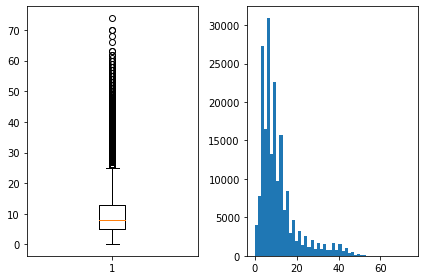

In [239]:
plt.subplot(1, 2, 1)
plt.boxplot(num_tokens)

plt.subplot(1, 2, 2)
plt.hist(num_tokens, bins=50)
plt.tight_layout()

plt.show()

In [240]:
# maxlen을 50으로 설정
max_len = 50

### - padding 추가

In [241]:
final_X_train = pad_sequences(final_X_train, padding='pre', maxlen=max_len)
final_X_test = pad_sequences(final_X_test, padding='pre', maxlen=max_len)

print(final_X_train.shape)
print(final_X_test.shape)

(146182, 50)
(49157, 50)


## 모델 설계 및 학습


In [242]:
WORD_VECTOR_DIM = 100  # 워드 벡터의 차원 수

my_model = Sequential()
my_model.add(Embedding(VOCAB_SIZE, WORD_VECTOR_DIM))
my_model.add(LSTM(60))
my_model.add(Dense(1, activation='sigmoid'))

my_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 100)         2031200   
_________________________________________________________________
lstm_23 (LSTM)               (None, 60)                38640     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 61        
Total params: 2,069,901
Trainable params: 2,069,901
Non-trainable params: 0
_________________________________________________________________


In [243]:
# callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [244]:
my_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = my_model.fit(final_X_train,
                       y_train,
                       epochs=20,
                       callbacks=[es, mc],
                       batch_size=60,
                       validation_split=0.2,
                       verbose=1)

Epoch 1/20
1950/1950 [==============================] - 37s 18ms/step - loss: 0.4317 - accuracy: 0.7948 - val_loss: 0.3462 - val_accuracy: 0.8497
Epoch 2/20
1950/1950 [==============================] - 34s 17ms/step - loss: 0.3233 - accuracy: 0.8598 - val_loss: 0.3346 - val_accuracy: 0.8563
Epoch 3/20
1950/1950 [==============================] - 34s 17ms/step - loss: 0.2934 - accuracy: 0.8760 - val_loss: 0.3196 - val_accuracy: 0.8622
Epoch 4/20
1950/1950 [==============================] - 34s 18ms/step - loss: 0.2710 - accuracy: 0.8872 - val_loss: 0.3178 - val_accuracy: 0.8618
Epoch 5/20
1950/1950 [==============================] - 34s 18ms/step - loss: 0.2554 - accuracy: 0.8966 - val_loss: 0.3222 - val_accuracy: 0.8622
Epoch 6/20
1950/1950 [==============================] - 34s 17ms/step - loss: 0.2393 - accuracy: 0.9028 - val_loss: 0.3249 - val_accuracy: 0.8609
Epoch 00006: early stopping


In [245]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

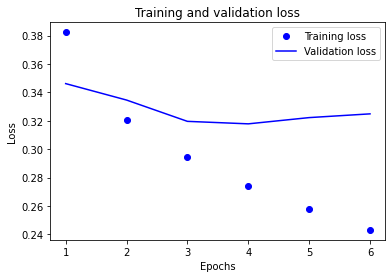

In [246]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

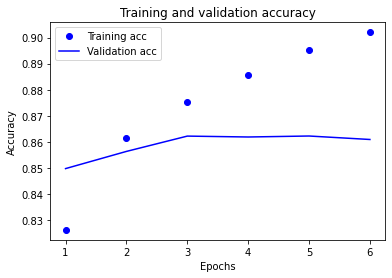

In [247]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [248]:
# 테스트셋을 통한 모델 평가
results = my_model.evaluate(final_X_test, y_test, verbose=2)

1537/1537 - 7s - loss: 0.3292 - accuracy: 0.8616


In [178]:
# 실제 리뷰를 분류하는 함수
def sentiment_predict(new_sentence):
    to_tokens = Okt()
    # tokenize
    new_sentence = to_tokens.morphs(new_sentence, stem=True)
    
    # stopwords 제거
    new_sentence = [word for word in new_sentence if not word in stopwords]
    
    # embedding
    embedding = tokenizer.texts_to_sequences([new_sentence])
    
    # padding
    padded = pad_sequences(embedding, maxlen=max_len)
    
    # prediction
    score = float(my_model.predict(padded))
    
    if score > 0.5:
        print(f"{score * 100:.2f}% 확률로 positive")
    else:
        print(f"{(1 - score)*100:.2f}% 확률로 negative")

In [249]:
sentiment_predict('2시간 내내 몰입할 수 있었던 영화')

93.81% 확률로 positive


In [250]:
sentiment_predict('감독이 전하고 싶었던 말이 뭔지 모르겠다')

98.14% 확률로 negative


In [251]:
sentiment_predict('그럭저럭')

90.44% 확률로 negative


In [252]:
# 하이퍼파라미터를 조정할 때마다 positive와 negative가 갈림
sentiment_predict('기대를 너무 많이 했나보다')

55.09% 확률로 negative


In [253]:
sentiment_predict('연인과 함께 보세요')

88.36% 확률로 positive


## gensim.models.Word2Vec 써보기

- gensim 버전 주의; pip install --upgrade gensim==3.8.3

In [ ]:
word2vec_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E7_sentimental_classification/data/ko.bin'

# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
another_model = Word2Vec(sentences=final_X_train, workers=100, sg=0)

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 1155, in _worker_loop
    class BrownCorpus(object):
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 946, in _do_train_job
    ----------
  File "gensim/models/word2vec_inner.pyx", line 638, in gensim.models.word2vec_inner.train_batch_cbow
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  F

In [ ]:
# model.wv.vectors.shape

## 평가 및 회고

#### - 데이터 전처리

- tokenizer는 Okt와 Mecab을 모두 사용해보고, Okt를 최종 채택했다.
    - 띄어쓰기 오류나 오타를 바로 잡아 주거나, normalize하는 기능이 Okt가 훨씬 좋다고 느껴졌다.
    - 그러나 Okt의 단점은 처리 시간이 오래 걸린다는 점이었다. 약 5만개의 word dictionary를 만드는 데 1시간 정도가 소요되었다.
    
#### - 모델 설계 및 학습
- 지난 노래 가사 생성 노드에서 얻었던 레슨을 상기하며, max_len을 대부분의 데이터를 포함하도록 크게 잡아 보았다.
    - max_len을 평균 값과 편차로 계산한 값이 29로 설정했을 때와 분포도를 보고 임의로 50으로 설정했을 때를 비교해 보았다.
    - 결과는 역시 max_len을 50으로 설정한 경우 val_acc이 더 높게 나왔다. \(0.85 -> 0.86\)
- 직접 word embedding을 하고 RNN layer를 설계한 모델로 학습시킨 결과와 gensim word2vec model로 학습시킨 결과 비교를 시도해 보았다.
    - LSTM layer와 sigmoid activation function을 이용한 모델로 정확히 accuracy 0.86을 얻을 수 있었다.
    - gensim Word2Vec model은 시간이 오래 걸려서 결국 정확한 결과를 확인하지 못했다. ㅠㅠ
- word_vector_dim은 값이 크다고 해서 accuracy가 더 높게 나오지는 않았다.
- optimizer는 adam에 비해 rmsprop을 사용하는 것이 더 val_accuracy가 조금 더 높게 나왔다. \(0.84 -> 0.85\)
- EarlyStopping과 ModelCheckpoint를 처음 사용해보았는데, 여러 번 학습시키면서 수동으로 최적의 epoch을 찾는 방식보다 훨씬 편리한 것 같다. best model을 저장해뒀다가 load하는 부분은 아직 구현하지 못했는데, loss, accuracy는 물론이고 parameter까지 저장이 가능하다고 하니 꼭 잘 사용해봐야겠다.
- review 문장에 대한 평가에서, prediction 확률이 50%대여서 매번 positive와 negative를 오가는 경우가 있었다. dataset에서 ratings 5에서 8점 사이는 neutral로 판단하고 포함하지 않았다고 했는데, 만약 그 부분까지 정제되어 dataset에 포함되었다면 어땠을까 하는 생각이 들었다.